In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
import pandas as pd
from tensorflow import keras

import numpy as np
import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics
from keras import backend as K
from keras.optimizers import RMSprop
from keras.utils.np_utils import to_categorical
import tensorflow as tf
import matplotlib.pyplot as plt
import os

In [3]:
df = pd.read_csv('jena_climate_2009_2016.csv')
df.shape[0]

420551

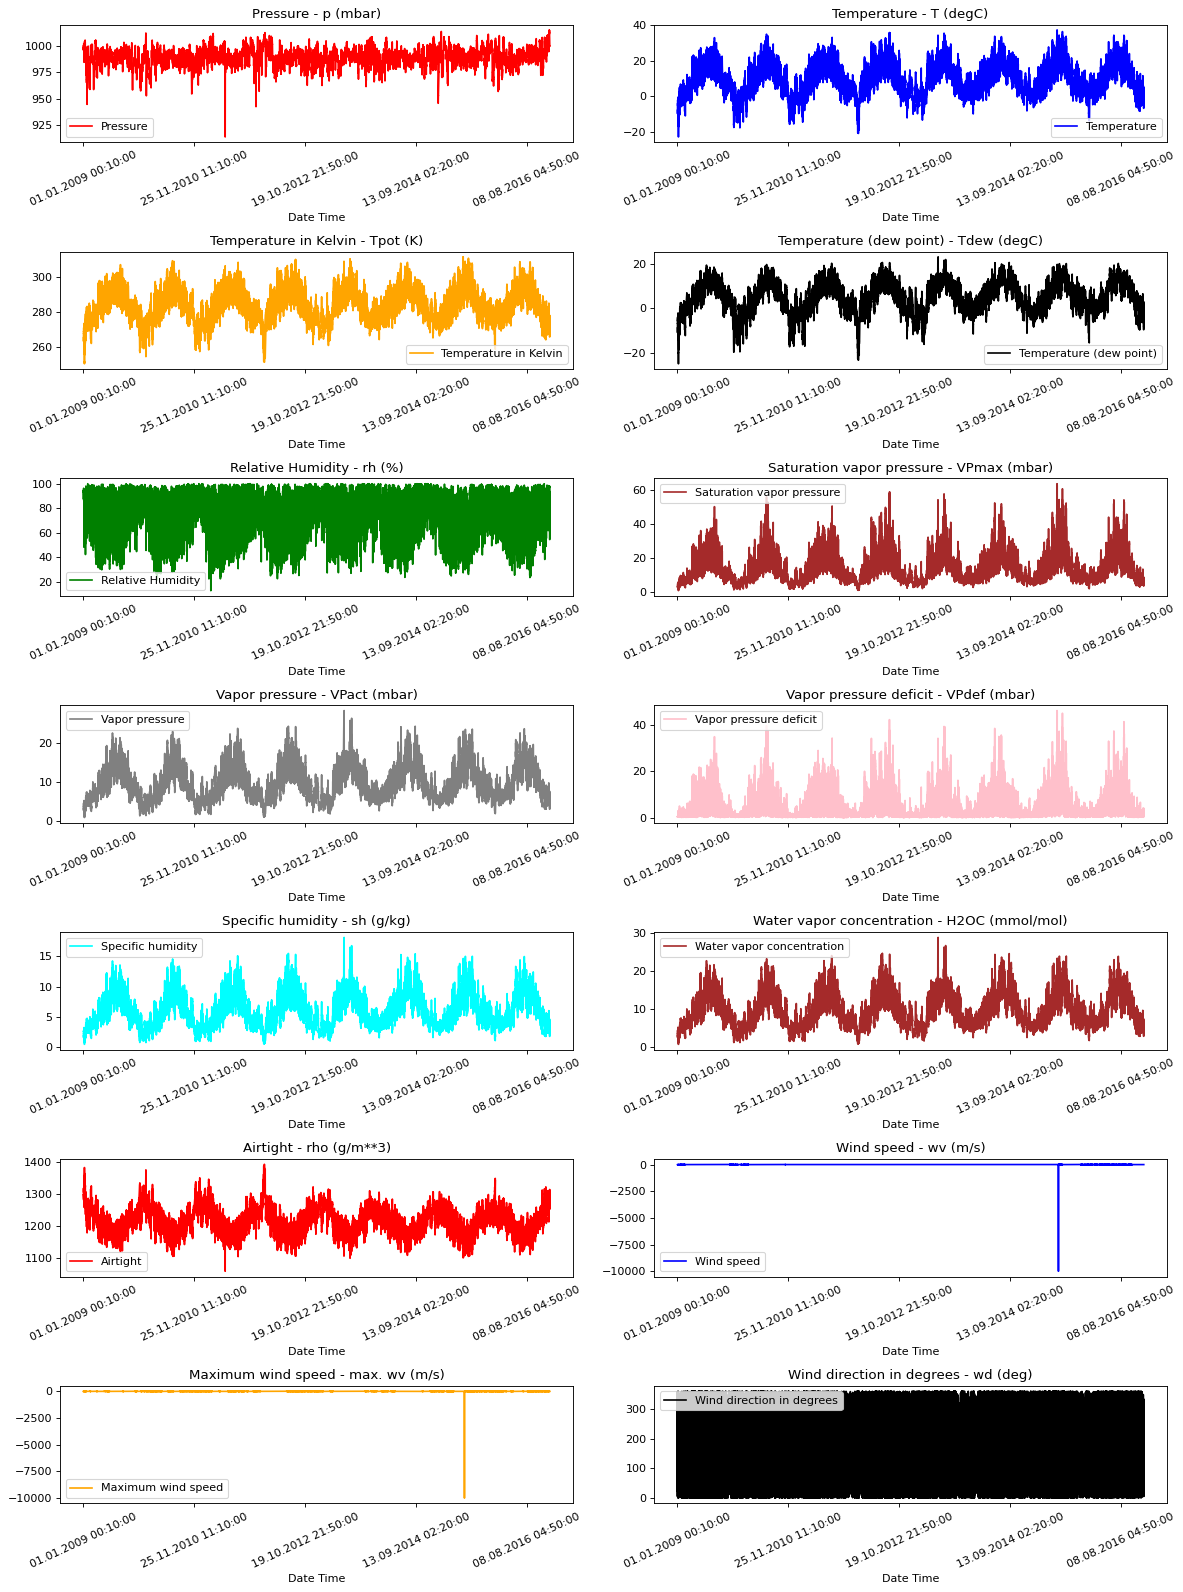

In [4]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "red",
    "blue",
    "orange",
    "black",
    "green",
    "brown",
    "gray",
    "pink",
    "cyan",
    "brown",
]
date_time_key = "Date Time"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)

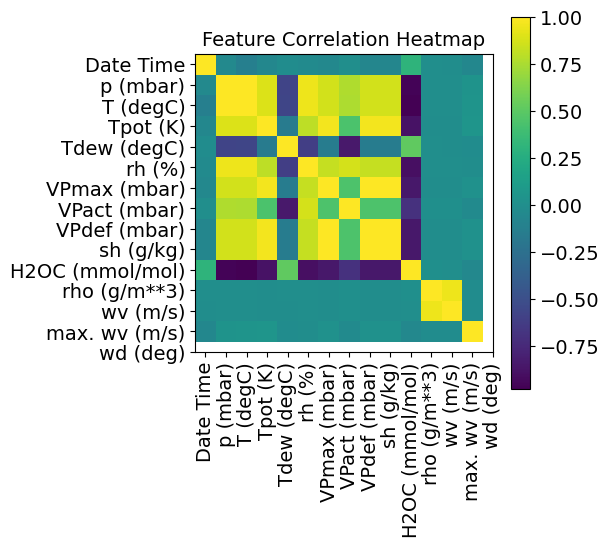

In [5]:
def heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


heatmap(df)

In [6]:
f = open('./jena_climate_2009_2016.csv')
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print("The headers are:", header)
print(len(lines))

The headers are: ['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [7]:
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

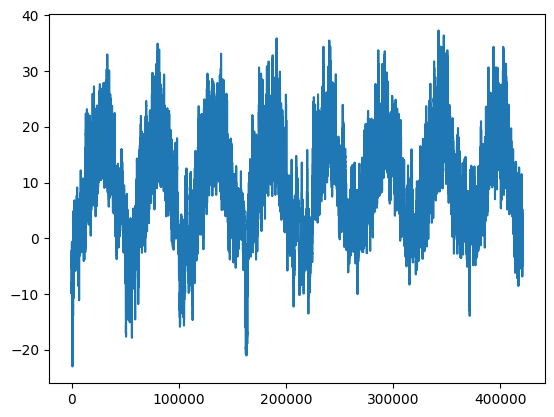

In [8]:
temp = float_data[:, 1]  # temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)
plt.show()

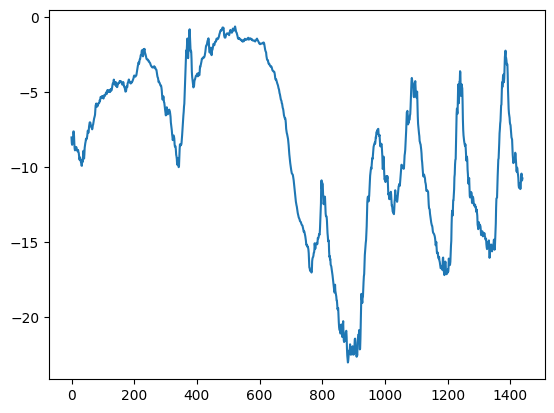

In [9]:
plt.plot(range(1440), temp[:1440])
plt.show()

In [10]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [11]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [12]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size

test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [13]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


In [14]:
celsius_mae = 0.29 * std[1]
celsius_mae

2.5672247338393395

In [15]:
def v(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [16]:
record=dict()

c:\Users\hp\anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  from ipykernel import kernelapp as app


Epoch 1/20
500/500 [==============================] - 11s 21ms/step - loss: 1.2818 - val_loss: 0.7115
Epoch 2/20
500/500 [==============================] - 10s 20ms/step - loss: 0.4498 - val_loss: 0.4565
Epoch 3/20
500/500 [==============================] - 9s 19ms/step - loss: 0.3020 - val_loss: 0.3632
Epoch 4/20
500/500 [==============================] - 10s 19ms/step - loss: 0.2703 - val_loss: 0.3108
Epoch 5/20
500/500 [==============================] - 10s 19ms/step - loss: 0.2558 - val_loss: 0.3130
Epoch 6/20
500/500 [==============================] - 10s 19ms/step - loss: 0.2480 - val_loss: 0.3284
Epoch 7/20
500/500 [==============================] - 10s 19ms/step - loss: 0.2381 - val_loss: 0.3244
Epoch 8/20
500/500 [==============================] - 10s 19ms/step - loss: 0.2321 - val_loss: 0.3644
Epoch 9/20
500/500 [==============================] - 10s 19ms/step - loss: 0.2281 - val_loss: 0.3228
Epoch 10/20
500/500 [==============================] - 10s 19ms/step - loss: 0.2233

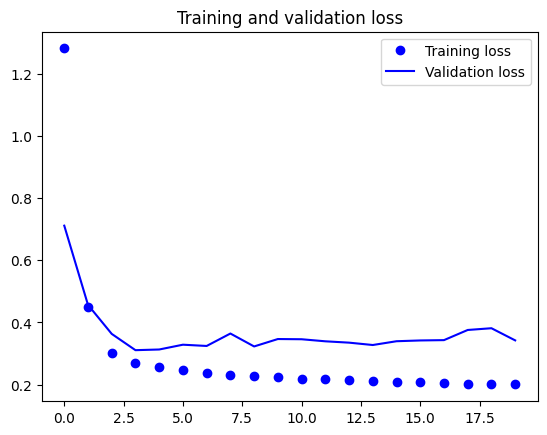

------------------TEST DATA EVALUATION-------------------


c:\Users\hp\anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:19: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.


MAE with Test data 1.073699951171875


In [17]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)
v(history)

print('------------------TEST DATA EVALUATION-------------------')
result = model.evaluate_generator(test_gen, steps = test_steps)
print('MAE with Test data', result)
record['model1'] = result

Epoch 1/10


c:\Users\hp\anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


500/500 [==============================] - 48s 92ms/step - loss: 0.3025 - val_loss: 0.2701
Epoch 2/10
500/500 [==============================] - 45s 90ms/step - loss: 0.2824 - val_loss: 0.2680
Epoch 3/10
500/500 [==============================] - 45s 90ms/step - loss: 0.2754 - val_loss: 0.2752
Epoch 4/10
500/500 [==============================] - 45s 90ms/step - loss: 0.2686 - val_loss: 0.2796
Epoch 5/10
500/500 [==============================] - 45s 90ms/step - loss: 0.2644 - val_loss: 0.2641
Epoch 6/10
500/500 [==============================] - 45s 90ms/step - loss: 0.2615 - val_loss: 0.2707
Epoch 7/10
500/500 [==============================] - 45s 91ms/step - loss: 0.2567 - val_loss: 0.2673
Epoch 8/10
500/500 [==============================] - 45s 91ms/step - loss: 0.2526 - val_loss: 0.2747
Epoch 9/10
500/500 [==============================] - 45s 91ms/step - loss: 0.2481 - val_loss: 0.2737
Epoch 10/10
500/500 [==============================] - 45s 91ms/step - loss: 0.2446 - val_los

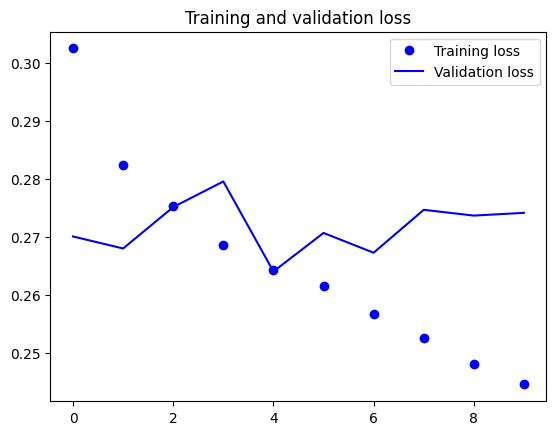

------------------TEST DATA EVALUATION-------------------


c:\Users\hp\anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:17: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  app.launch_new_instance()


MAE with Test data 0.29050758481025696


In [18]:

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=10,
                              validation_data=val_gen,
                              validation_steps=val_steps)
v(history)
print('------------------TEST DATA EVALUATION-------------------')
result = model.evaluate_generator(test_gen, steps = test_steps)
print('MAE with Test data', result)
record['model1'] = result

Epoch 1/40


c:\Users\hp\anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  app.launch_new_instance()


500/500 [==============================] - 67s 131ms/step - loss: 0.3269 - val_loss: 0.2844
Epoch 2/40
500/500 [==============================] - 61s 123ms/step - loss: 0.3065 - val_loss: 0.2737
Epoch 3/40
500/500 [==============================] - 61s 123ms/step - loss: 0.2991 - val_loss: 0.2711
Epoch 4/40
500/500 [==============================] - 63s 125ms/step - loss: 0.2964 - val_loss: 0.2689
Epoch 5/40
500/500 [==============================] - 63s 125ms/step - loss: 0.2917 - val_loss: 0.2696
Epoch 6/40
500/500 [==============================] - 63s 126ms/step - loss: 0.2856 - val_loss: 0.2971
Epoch 7/40
500/500 [==============================] - 63s 125ms/step - loss: 0.2801 - val_loss: 0.2700
Epoch 8/40
500/500 [==============================] - 62s 124ms/step - loss: 0.2780 - val_loss: 0.2835
Epoch 9/40
500/500 [==============================] - 62s 123ms/step - loss: 0.2763 - val_loss: 0.2783
Epoch 10/40
500/500 [==============================] - 64s 128ms/step - loss: 0.2726

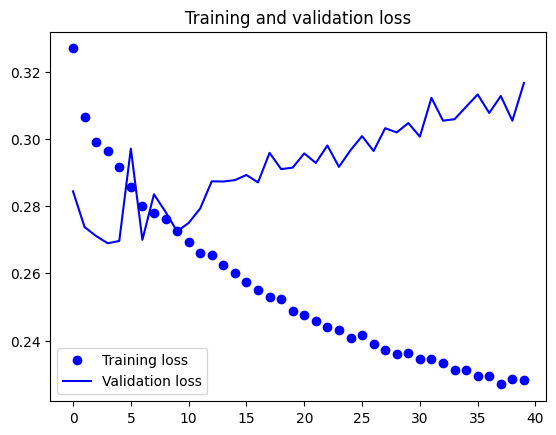

------------------TEST DATA EVALUATION-------------------


c:\Users\hp\anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:20: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.


MAE with Test data 0.3279956877231598


In [19]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)
v(history)
print('------------------TEST DATA EVALUATION-------------------')
result = model.evaluate_generator(test_gen, steps = test_steps)
print('MAE with Test data', result)
record['model1'] = result

Epoch 1/15


c:\Users\hp\anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


500/500 [==============================] - 217s 426ms/step - loss: 0.3236 - val_loss: 0.2779
Epoch 2/15
500/500 [==============================] - 197s 393ms/step - loss: 0.3025 - val_loss: 0.2742
Epoch 3/15
500/500 [==============================] - 206s 413ms/step - loss: 0.2939 - val_loss: 0.2699
Epoch 4/15
500/500 [==============================] - 188s 376ms/step - loss: 0.2878 - val_loss: 0.2685
Epoch 5/15
500/500 [==============================] - 190s 379ms/step - loss: 0.2796 - val_loss: 0.2663
Epoch 6/15
500/500 [==============================] - 186s 372ms/step - loss: 0.2751 - val_loss: 0.2704
Epoch 7/15
500/500 [==============================] - 185s 370ms/step - loss: 0.2698 - val_loss: 0.2720
Epoch 8/15
500/500 [==============================] - 203s 407ms/step - loss: 0.2643 - val_loss: 0.2791
Epoch 9/15
500/500 [==============================] - 225s 449ms/step - loss: 0.2620 - val_loss: 0.2734
Epoch 10/15
500/500 [==============================] - 200s 400ms/step - lo

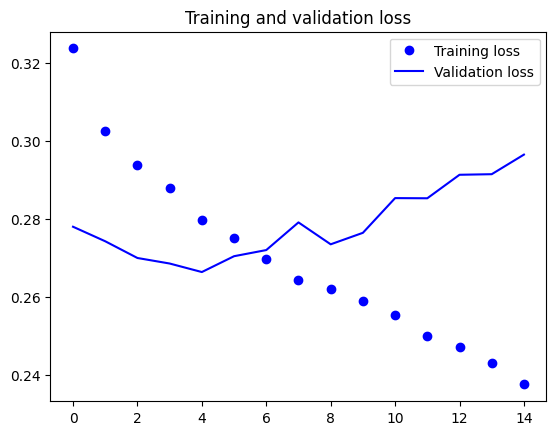

------------------TEST DATA EVALUATION-------------------


c:\Users\hp\anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:24: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.


MAE with Test data 0.307290643453598


In [20]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=15,
                              validation_data=val_gen,
                              validation_steps=val_steps)
v(history)
print('------------------TEST DATA EVALUATION-------------------')
result = model.evaluate_generator(test_gen, steps = test_steps)
print('MAE with Test data', result)
record['model1'] = result

In [21]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=15,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/15


c:\Users\hp\anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  from ipykernel import kernelapp as app


500/500 [==============================] - 11s 22ms/step - loss: 1.4845 - val_loss: 0.8003
Epoch 2/15
500/500 [==============================] - 10s 19ms/step - loss: 0.5120 - val_loss: 0.3666
Epoch 3/15
500/500 [==============================] - 10s 19ms/step - loss: 0.2978 - val_loss: 0.3082
Epoch 4/15
500/500 [==============================] - 11s 22ms/step - loss: 0.2708 - val_loss: 0.3251
Epoch 5/15
500/500 [==============================] - 10s 19ms/step - loss: 0.2565 - val_loss: 0.3495
Epoch 6/15
500/500 [==============================] - 9s 19ms/step - loss: 0.2462 - val_loss: 0.3120
Epoch 7/15
500/500 [==============================] - 9s 19ms/step - loss: 0.2362 - val_loss: 0.3114
Epoch 8/15
500/500 [==============================] - 9s 19ms/step - loss: 0.2320 - val_loss: 0.3155
Epoch 9/15
500/500 [==============================] - 9s 19ms/step - loss: 0.2258 - val_loss: 0.3239
Epoch 10/15
500/500 [==============================] - 9s 19ms/step - loss: 0.2228 - val_loss: 0.

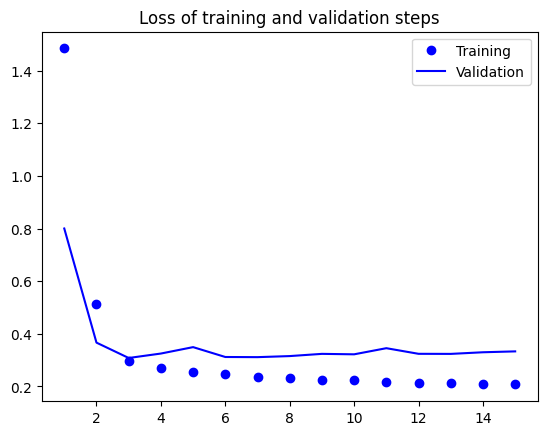

In [22]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training')
plt.plot(epochs, val_loss, 'b', label='Validation')
plt.title('Loss of training and validation steps')
plt.legend()

plt.show()

In [23]:
result = model.evaluate_generator(test_gen, steps=test_steps)
print('\n', result)

c:\Users\hp\anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.



 1.1444201469421387


In [26]:
###GRU

In [27]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20


c:\Users\hp\anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


500/500 [==============================] - 52s 101ms/step - loss: 0.3002 - val_loss: 0.2690
Epoch 2/20
500/500 [==============================] - 49s 98ms/step - loss: 0.2843 - val_loss: 0.2644
Epoch 3/20
500/500 [==============================] - 49s 98ms/step - loss: 0.2769 - val_loss: 0.2616
Epoch 4/20
500/500 [==============================] - 49s 99ms/step - loss: 0.2735 - val_loss: 0.2648
Epoch 5/20
500/500 [==============================] - 49s 99ms/step - loss: 0.2687 - val_loss: 0.2689
Epoch 6/20
500/500 [==============================] - 53s 106ms/step - loss: 0.2663 - val_loss: 0.2644
Epoch 7/20
500/500 [==============================] - 50s 99ms/step - loss: 0.2628 - val_loss: 0.2657
Epoch 8/20
500/500 [==============================] - 50s 100ms/step - loss: 0.2571 - val_loss: 0.2632
Epoch 9/20
500/500 [==============================] - 50s 100ms/step - loss: 0.2532 - val_loss: 0.2737
Epoch 10/20
500/500 [==============================] - 50s 100ms/step - loss: 0.2512 - va

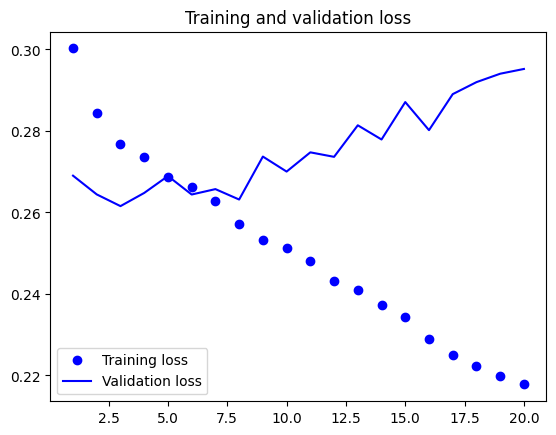

In [28]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [29]:
model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=5,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/5
  2/500 [..............................] - ETA: 35s - loss: 0.2289

c:\Users\hp\anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


500/500 [==============================] - 50s 99ms/step - loss: 0.2162 - val_loss: 0.2987
Epoch 2/5
500/500 [==============================] - 49s 98ms/step - loss: 0.2133 - val_loss: 0.3043
Epoch 3/5
500/500 [==============================] - 50s 100ms/step - loss: 0.2082 - val_loss: 0.3079
Epoch 4/5
500/500 [==============================] - 50s 99ms/step - loss: 0.2072 - val_loss: 0.3030
Epoch 5/5
500/500 [==============================] - 50s 100ms/step - loss: 0.2032 - val_loss: 0.3080


In [30]:
result = model.evaluate_generator(test_gen, steps=test_steps)
print('\n', result)

c:\Users\hp\anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.



 0.31887635588645935


In [31]:
###GRU with dropout

In [32]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1]), dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20


c:\Users\hp\anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


500/500 [==============================] - 70s 137ms/step - loss: 0.3199 - val_loss: 0.2785
Epoch 2/20
500/500 [==============================] - 60s 121ms/step - loss: 0.3046 - val_loss: 0.2731
Epoch 3/20
500/500 [==============================] - 61s 121ms/step - loss: 0.2997 - val_loss: 0.2681
Epoch 4/20
500/500 [==============================] - 60s 121ms/step - loss: 0.2955 - val_loss: 0.2710
Epoch 5/20
500/500 [==============================] - 62s 124ms/step - loss: 0.2901 - val_loss: 0.2706
Epoch 6/20
500/500 [==============================] - 62s 125ms/step - loss: 0.2855 - val_loss: 0.2688
Epoch 7/20
500/500 [==============================] - 65s 131ms/step - loss: 0.2805 - val_loss: 0.2714
Epoch 8/20
500/500 [==============================] - 64s 127ms/step - loss: 0.2763 - val_loss: 0.2727
Epoch 9/20
500/500 [==============================] - 64s 128ms/step - loss: 0.2730 - val_loss: 0.2737
Epoch 10/20
500/500 [==============================] - 64s 128ms/step - loss: 0.2692

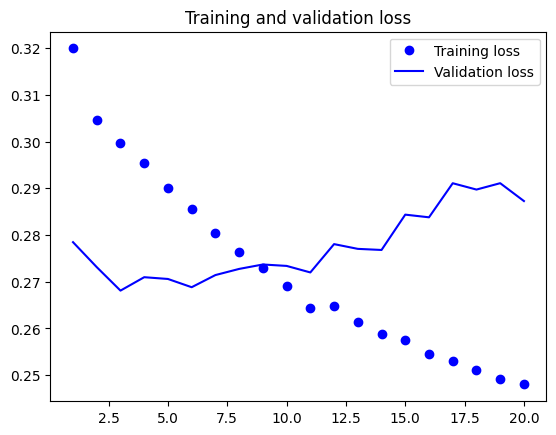

In [33]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [34]:
model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=10,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/10
  1/500 [..............................] - ETA: 58s - loss: 0.2556

c:\Users\hp\anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


500/500 [==============================] - 58s 117ms/step - loss: 0.2439 - val_loss: 0.2887
Epoch 2/10
500/500 [==============================] - 59s 117ms/step - loss: 0.2444 - val_loss: 0.2904
Epoch 3/10
500/500 [==============================] - 59s 117ms/step - loss: 0.2407 - val_loss: 0.2968
Epoch 4/10
500/500 [==============================] - 59s 117ms/step - loss: 0.2412 - val_loss: 0.2953
Epoch 5/10
500/500 [==============================] - 59s 118ms/step - loss: 0.2396 - val_loss: 0.2919
Epoch 6/10
500/500 [==============================] - 59s 118ms/step - loss: 0.2396 - val_loss: 0.2985
Epoch 7/10
500/500 [==============================] - 59s 119ms/step - loss: 0.2381 - val_loss: 0.2996
Epoch 8/10
500/500 [==============================] - 59s 119ms/step - loss: 0.2351 - val_loss: 0.3047
Epoch 9/10
500/500 [==============================] - 59s 118ms/step - loss: 0.2350 - val_loss: 0.3013
Epoch 10/10
500/500 [==============================] - 60s 120ms/step - loss: 0.2335

In [35]:
result = model.evaluate_generator(test_gen, steps=test_steps)
print('\n', result)

c:\Users\hp\anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.



 0.3101048171520233


In [36]:
###LSTM with dropout

In [37]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.LSTM(32, input_shape=(None, float_data.shape[-1]), dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=15,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/15


c:\Users\hp\anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


500/500 [==============================] - 67s 130ms/step - loss: 0.3168 - val_loss: 0.2833
Epoch 2/15
500/500 [==============================] - 65s 131ms/step - loss: 0.2944 - val_loss: 0.2782
Epoch 3/15
500/500 [==============================] - 65s 131ms/step - loss: 0.2867 - val_loss: 0.2717
Epoch 4/15
500/500 [==============================] - 66s 131ms/step - loss: 0.2787 - val_loss: 0.2764
Epoch 5/15
500/500 [==============================] - 65s 130ms/step - loss: 0.2721 - val_loss: 0.2738
Epoch 6/15
500/500 [==============================] - 64s 128ms/step - loss: 0.2692 - val_loss: 0.2722
Epoch 7/15
500/500 [==============================] - 64s 129ms/step - loss: 0.2633 - val_loss: 0.2816
Epoch 8/15
500/500 [==============================] - 64s 129ms/step - loss: 0.2592 - val_loss: 0.2798
Epoch 9/15
500/500 [==============================] - 64s 129ms/step - loss: 0.2541 - val_loss: 0.2920
Epoch 10/15
500/500 [==============================] - 64s 129ms/step - loss: 0.2504

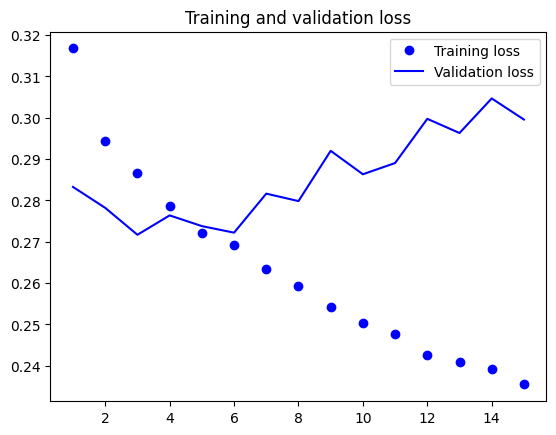

In [38]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [39]:
result = model.evaluate_generator(test_gen, steps=test_steps)
print('\n', result)

c:\Users\hp\anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.



 0.30857792496681213


###Stacking GRU

In [40]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5, return_sequences=True, input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu', dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=40,
                             validation_data=val_gen,
                             validation_steps=val_steps)

Epoch 1/40


c:\Users\hp\anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  from ipykernel import kernelapp as app


500/500 [==============================] - 180s 353ms/step - loss: 0.3188 - val_loss: 0.2804
Epoch 2/40
500/500 [==============================] - 4734s 9s/step - loss: 0.3017 - val_loss: 0.2843
Epoch 3/40
500/500 [==============================] - 260s 520ms/step - loss: 0.2970 - val_loss: 0.2778
Epoch 4/40
500/500 [==============================] - 250s 500ms/step - loss: 0.2903 - val_loss: 0.2700
Epoch 5/40
500/500 [==============================] - 245s 488ms/step - loss: 0.2864 - val_loss: 0.2790
Epoch 6/40
500/500 [==============================] - 276s 551ms/step - loss: 0.2812 - val_loss: 0.2749
Epoch 7/40
500/500 [==============================] - 293s 585ms/step - loss: 0.2741 - val_loss: 0.2667
Epoch 8/40
500/500 [==============================] - 256s 511ms/step - loss: 0.2687 - val_loss: 0.2820
Epoch 9/40
500/500 [==============================] - 233s 467ms/step - loss: 0.2636 - val_loss: 0.2721
Epoch 10/40
500/500 [==============================] - 235s 470ms/step - loss

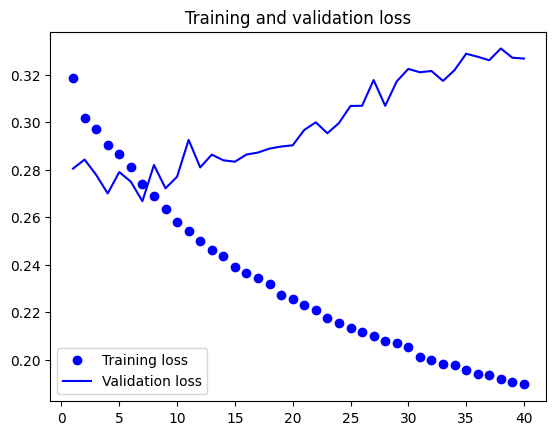

In [41]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [42]:
result = model.evaluate_generator(test_gen, steps=test_steps)
print('\n', result)

c:\Users\hp\anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.



 0.35239115357398987


In [43]:
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=40,
                             validation_data=val_gen,
                             validation_steps=val_steps)

Epoch 1/40


c:\Users\hp\anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


500/500 [==============================] - 190s 380ms/step - loss: 0.1891 - val_loss: 0.3408
Epoch 2/40
500/500 [==============================] - 198s 396ms/step - loss: 0.1880 - val_loss: 0.3358
Epoch 3/40
500/500 [==============================] - 203s 406ms/step - loss: 0.1857 - val_loss: 0.3346
Epoch 4/40
500/500 [==============================] - 198s 396ms/step - loss: 0.1858 - val_loss: 0.3388
Epoch 5/40
500/500 [==============================] - 182s 364ms/step - loss: 0.1847 - val_loss: 0.3366
Epoch 6/40
500/500 [==============================] - 187s 375ms/step - loss: 0.1842 - val_loss: 0.3398
Epoch 7/40
500/500 [==============================] - 190s 380ms/step - loss: 0.1827 - val_loss: 0.3477
Epoch 8/40
500/500 [==============================] - 187s 374ms/step - loss: 0.1817 - val_loss: 0.3468
Epoch 9/40
500/500 [==============================] - 184s 368ms/step - loss: 0.1811 - val_loss: 0.3393
Epoch 10/40
500/500 [==============================] - 187s 373ms/step - lo

In [44]:
result = model.evaluate_generator(test_gen, steps=test_steps)
print('\n', result)

c:\Users\hp\anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.



 0.3691635727882385


###LSTM Stacked

In [45]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model2 = Sequential()
model2.add(layers.LSTM(32, dropout=0.1, recurrent_dropout=0.5, return_sequences=True, input_shape=(None, float_data.shape[-1])))
model2.add(layers.LSTM(64, activation='relu', dropout=0.1, recurrent_dropout=0.5))
model2.add(layers.Dense(1))

model2.compile(optimizer=RMSprop(), loss='mae')
history2 = model2.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=40,
                             validation_data=val_gen,
                             validation_steps=val_steps)

Epoch 1/40


c:\Users\hp\anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  from ipykernel import kernelapp as app


500/500 [==============================] - 245s 480ms/step - loss: 0.3241 - val_loss: 0.2893
Epoch 2/40
500/500 [==============================] - 259s 517ms/step - loss: 0.2953 - val_loss: 0.2726
Epoch 3/40
500/500 [==============================] - 232s 464ms/step - loss: 0.2849 - val_loss: 0.2900
Epoch 4/40
500/500 [==============================] - 240s 480ms/step - loss: 0.2776 - val_loss: 65174.2578
Epoch 5/40
500/500 [==============================] - 244s 489ms/step - loss: 0.2687 - val_loss: 0.3656
Epoch 6/40
500/500 [==============================] - 269s 539ms/step - loss: 0.2627 - val_loss: 0.2927
Epoch 7/40
500/500 [==============================] - 262s 524ms/step - loss: 0.2550 - val_loss: 0.2955
Epoch 8/40
500/500 [==============================] - 301s 603ms/step - loss: 0.2506 - val_loss: 0.3001
Epoch 9/40
500/500 [==============================] - 297s 594ms/step - loss: 0.2430 - val_loss: 0.3122
Epoch 10/40
500/500 [==============================] - 240s 481ms/step 

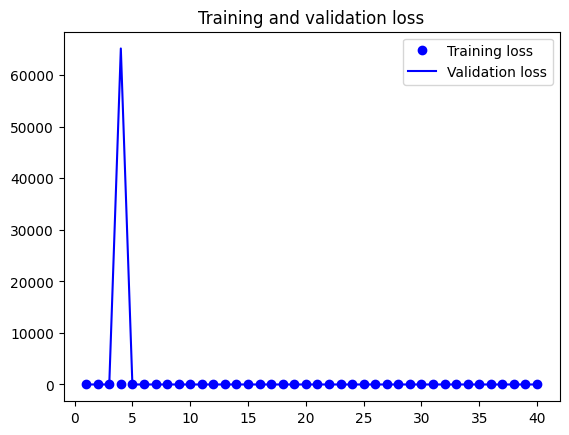

In [46]:
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [47]:
result = model2.evaluate_generator(test_gen, steps=test_steps)
print('\n', result)

c:\Users\hp\anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.



 0.36582714319229126
